In [55]:
#**************************#
#import packages
#**************************#

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer

#from sklearn.preprocessing import MinMaxScaler
#from sklearn.impute import SimpleImputer 

from sklearn.feature_selection import SelectKBest , chi2, f_classif

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix , classification_report, roc_auc_score, f1_score, accuracy_score, cohen_kappa_score, log_loss
from sklearn import tree

from sklearn.ensemble import RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import pandas_profiling
import warnings
warnings.filterwarnings('ignore')

                      count         mean           std           min  \
Data Year - Fiscal  92872.0  2004.105888      9.875926  1.979000e+03   
Tobin's Q           92620.0    25.369008    902.818813  9.283364e-03   
EPS                 92867.0   -14.461355   2195.467288 -3.840000e+05   
Liquidity           92625.0    -2.631237    121.610921 -2.596852e+04   
Profitability       92625.0   -29.537274    677.230667 -7.968200e+04   
Productivity        92625.0    -1.222870     35.885556 -5.093000e+03   
Leverage Ratio      92846.0     1.345316    253.038093 -7.811000e+03   
Asset Turnover      92625.0     1.053613      2.115945 -3.159000e+01   
Operational Margin  87315.0    -7.915485    214.460079 -3.017570e+04   
Return on Equity    92864.0    -2.112382    352.596902 -8.887514e+04   
Market Book Ratio   92815.0   358.506265  26063.637981 -3.151500e+06   
Assets Growth       86171.0     1.294075     73.769522 -1.000000e+00   
Sales Growth        86171.0     1.900108    177.632638 -2.743103

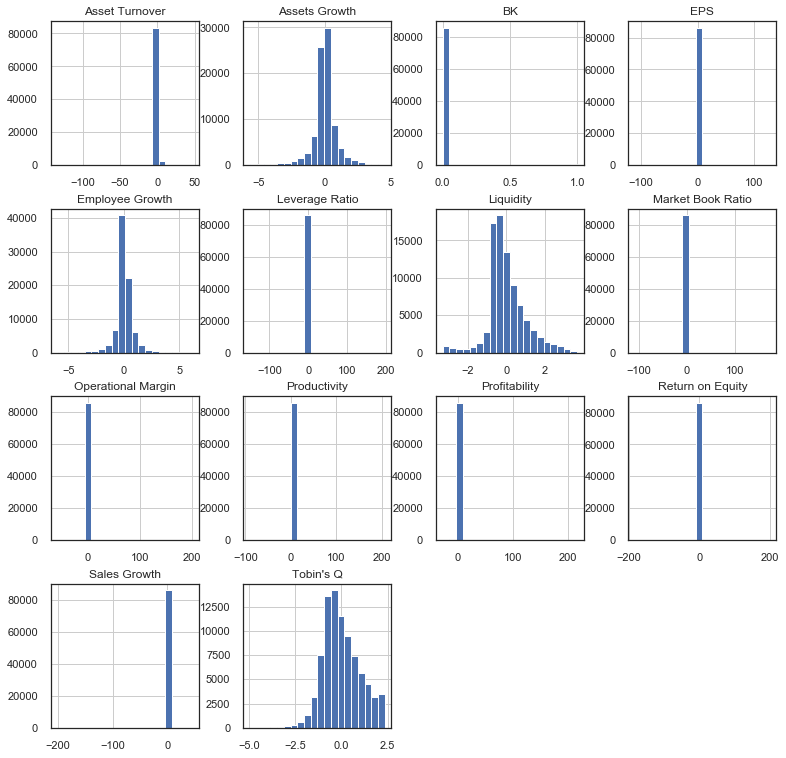

In [12]:
#**************************#
#import and Explore data
#**************************#

df = pd.read_excel("data/Bankruptcy_data_Final.xlsx")
df.head()

data = df.copy()

#Data Statistics
print(df.describe().transpose())

# Check missing value
print(df.isnull().sum())


#pandas_profiling.ProfileReport(df)

# target distribution -- Class0: 99.4%, Class1 : 0.6%
print(df["BK"].value_counts())

#****************************#
#Data Cleaning and Engineering 
#****************************#
#Drop rows with more than 3 missing values
df = df[df.isnull().sum(axis=1) < 3]

#Fill remaining missing value with 0
df = df.fillna(0)

#Feature Scaling
df.drop(['Data Year - Fiscal' ], axis = 1 , inplace = True)

num_features = [col for col in df.columns if col != 'BK']

scaler = PowerTransformer(method='yeo-johnson')
df[num_features] = scaler.fit_transform(df[num_features])

#Histogram
df.hist(figsize = (13,13), bins = 20)
plt.show()

#Export the cleaned data
df.to_csv('data/cleaned_data.csv', index = False)

In [130]:
df = pd.read_csv('data/cleaned_data.csv')

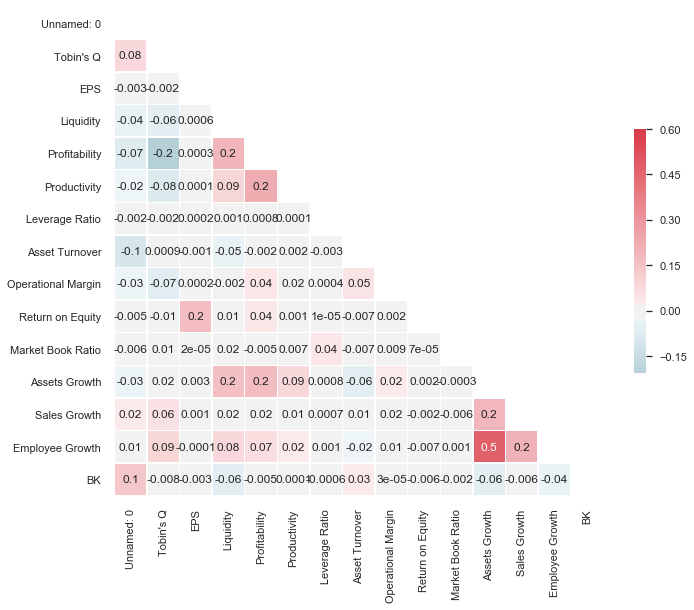

In [3]:
sns.set(style="white")

corr_matrix = df.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.6, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True, fmt=".0")
plt.show()

In [146]:
target = "BK"
features = list(df.columns)

features = [f for f in features if f!=target]

X = df[features].reset_index(drop=True).values
y = df[target].values

In [36]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)
from collections import Counter
print(sorted(Counter(y_resampled).items()))

[(0, 85418), (1, 85418)]


In [133]:
#X_train, X_test, y_train , y_test = train_test_split(X, y, random_state = 42 , test_size = 0.2 )

In [47]:
#Split data to train and test sets
X_train, X_test, y_train , y_test = train_test_split(X_resampled, y_resampled, random_state = 42 , test_size = 0.2 )

In [62]:
# target = "BK"
# features = list(train.columns)

# features = [f for f in features if f!=target]

# X_train = train[features].reset_index(drop=True)
# y_train = train[[target]].reset_index(drop=True)


# X_test = test[features].reset_index(drop=True)
# y_test = test[[target]].reset_index(drop=True)

In [134]:
def GridSearch_func(X,y, estimator, param_grid, cv=10 , scoring = 'roc_auc'):

    grid_search = GridSearchCV(estimator, param_grid, cv=cv,
                           scoring=scoring)
    grid_search.fit(X, y)
    print ("best parameters: ", grid_search.best_params_)
    #print(f"best {scoring} score during training: ", grid_search.best_score_)
    print("-------"*10)
    means = grid_search.cv_results_['mean_test_score']
    stds = grid_search.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()
    print(f"mean of {scoring} scores during validation: {sum(means)/len(means):0.3f}")
    print("-------"*10)
    best_model = grid_search.best_estimator_
    print ("best_model: ", best_model)
    
    return best_model

In [135]:
def metrics( clf, X_test , y_test = y_test):
    
    y_pred = clf.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print()
    print(cm)
    print("-----"*5)
    
    print(classification_report(y_test, y_pred))
    print("-----"*5)
    
    y_proba = clf.predict_proba(X_test)
    y_scores = y_proba[:, 1]
    auc = roc_auc_score (y_test, y_scores)
    
    print()
    print(f"ROC AUC score: {auc:.3f}")

    f1 = f1_score(y_test, y_pred)
    print(f"f1 score: {f1:.3f}")
    
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.3f}")
    
    kappa = cohen_kappa_score(y_test, y_pred)
    print(f"Kappa: {kappa:.3f}".format())
    
    logLoss = log_loss(y_test, y_scores)
    print(f"Log loss: {logLoss:.3f}".format())
    
    metrics = pd.DataFrame({"Accuracy" :[acc], "AUC" : [auc], "f1": [f1], "Kappa": [kappa], "Log Loss": [logLoss]}).round(3)
    return metrics

In [136]:
#Logistic Regression
lg_clf = LogisticRegression(n_jobs = -1  , class_weight= {0 : 0.01, 1: 0.99})
param_grid_lg = [{"penalty" :['l1', 'l2'] , "C" :[ 0.1, 1 ]}]
lg_model = GridSearch_func(X = X_train, y= np.ravel(y_train),
                           estimator = lg_clf, param_grid = param_grid_lg, cv= 5  , scoring = "roc_auc" )

best parameters:  {'C': 0.1, 'penalty': 'l2'}
----------------------------------------------------------------------
nan (+/-nan) for {'C': 0.1, 'penalty': 'l1'}
0.775 (+/-0.024) for {'C': 0.1, 'penalty': 'l2'}
nan (+/-nan) for {'C': 1, 'penalty': 'l1'}
0.775 (+/-0.025) for {'C': 1, 'penalty': 'l2'}

mean of roc_auc scores during validation: nan
----------------------------------------------------------------------
best_model:  LogisticRegression(C=0.1, class_weight={0: 0.01, 1: 0.99}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [137]:
print("Logistic Regression Classifier" )
print()
log_reg_metrics = metrics(lg_model, X_test, y_test)

Logistic Regression Classifier

Confusion Matrix:

[[15367  1717]
 [   46    65]]
-------------------------
              precision    recall  f1-score   support

           0       1.00      0.90      0.95     17084
           1       0.04      0.59      0.07       111

    accuracy                           0.90     17195
   macro avg       0.52      0.74      0.51     17195
weighted avg       0.99      0.90      0.94     17195

-------------------------

ROC AUC score: 0.785
f1 score: 0.069
Accuracy: 0.897
Kappa: 0.057
Log loss: 0.416


In [46]:
from imblearn.over_sampling import SMOTE, ADASYN
X_resampled, y_resampled = SMOTE().fit_resample(X, y)
print(sorted(Counter(y_resampled).items()))

#Split data to train and test sets
X_train, X_test, y_train , y_test = train_test_split(X_resampled, y_resampled, random_state = 42 , test_size = 0.2 )

[(0, 85418), (1, 85418)]


In [92]:
lg_model = GridSearch_func(X = X_train, y= np.ravel(y_train),
                           estimator = lg_clf, param_grid = param_grid_lg, cv= 5  , scoring = "roc_auc" )

best parameters:  {'C': 0.1, 'penalty': 'l2'}
----------------------------------------------------------------------
nan (+/-nan) for {'C': 0.1, 'penalty': 'l1'}
0.918 (+/-0.004) for {'C': 0.1, 'penalty': 'l2'}
nan (+/-nan) for {'C': 1, 'penalty': 'l1'}
0.918 (+/-0.003) for {'C': 1, 'penalty': 'l2'}

mean of roc_auc scores during validation: nan
----------------------------------------------------------------------
best_model:  LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [93]:
print("Logistic Regression Classifier" )
print()
log_reg_metrics = metrics(lg_model, X_test, y_test)

Logistic Regression Classifier

Confusion Matrix:

[[15155  1908]
 [ 2785 14320]]
-------------------------
              precision    recall  f1-score   support

           0       0.84      0.89      0.87     17063
           1       0.88      0.84      0.86     17105

    accuracy                           0.86     34168
   macro avg       0.86      0.86      0.86     34168
weighted avg       0.86      0.86      0.86     34168

-------------------------

ROC AUC score: 0.918
f1 score: 0.859
Accuracy: 0.863
Kappa: 0.725
Log loss: 0.367


In [51]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

clf = LDA()
clf.fit(X_train, y_train)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [56]:
print("lda" )
print()
lda_reg_metrics = metrics(clf, X_test, y_test)

lda

Confusion Matrix:

[[12190  4873]
 [ 4898 12207]]
-------------------------
              precision    recall  f1-score   support

           0       0.71      0.71      0.71     17063
           1       0.71      0.71      0.71     17105

    accuracy                           0.71     34168
   macro avg       0.71      0.71      0.71     34168
weighted avg       0.71      0.71      0.71     34168

-------------------------

ROC AUC score: 0.792
f1 score: 0.714
Accuracy: 0.714
Kappa: 0.428
Log loss: 0.568


In [58]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

qda = QDA()
qda.fit(X_train, y_train)


QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001)

In [59]:
print("qda" )
print()
qda_reg_metrics = metrics(qda, X_test, y_test)

lda

Confusion Matrix:

[[ 1704 15359]
 [  584 16521]]
-------------------------
              precision    recall  f1-score   support

           0       0.74      0.10      0.18     17063
           1       0.52      0.97      0.67     17105

    accuracy                           0.53     34168
   macro avg       0.63      0.53      0.43     34168
weighted avg       0.63      0.53      0.43     34168

-------------------------

ROC AUC score: 0.784
f1 score: 0.675
Accuracy: 0.533
Kappa: 0.066
Log loss: 5.118


In [62]:
X_resampled, y_resampled = ADASYN().fit_resample(X, y)
print(sorted(Counter(y_resampled).items()))


#Split data to train and test sets
X_train, X_test, y_train , y_test = train_test_split(X_resampled, y_resampled, random_state = 42 , test_size = 0.2 )

[(0, 68355), (1, 68316)]


In [63]:
qda = QDA()
qda.fit(X_train, y_train)
qda_reg_metrics = metrics(qda, X_test, y_test)

Confusion Matrix:

[[ 1418 12262]
 [  456 13199]]
-------------------------
              precision    recall  f1-score   support

           0       0.76      0.10      0.18     13680
           1       0.52      0.97      0.67     13655

    accuracy                           0.53     27335
   macro avg       0.64      0.54      0.43     27335
weighted avg       0.64      0.53      0.43     27335

-------------------------

ROC AUC score: 0.785
f1 score: 0.675
Accuracy: 0.535
Kappa: 0.070
Log loss: 5.434


In [64]:
clf = LDA()
clf.fit(X_train, y_train)
lda_reg_metrics = metrics(clf, X_test, y_test)

Confusion Matrix:

[[9626 4054]
 [3898 9757]]
-------------------------
              precision    recall  f1-score   support

           0       0.71      0.70      0.71     13680
           1       0.71      0.71      0.71     13655

    accuracy                           0.71     27335
   macro avg       0.71      0.71      0.71     27335
weighted avg       0.71      0.71      0.71     27335

-------------------------

ROC AUC score: 0.789
f1 score: 0.710
Accuracy: 0.709
Kappa: 0.418
Log loss: 0.570


In [78]:
X_train, X_test, y_train , y_test = train_test_split(X, y, random_state = 42 , test_size = 0.2 )

In [80]:
qda = QDA()
qda.fit(X_train, y_train)
qda_reg_metrics = metrics(qda, X_test, y_test)

Confusion Matrix:

[[ 2623 14461]
 [   11   100]]
-------------------------
              precision    recall  f1-score   support

           0       1.00      0.15      0.27     17084
           1       0.01      0.90      0.01       111

    accuracy                           0.16     17195
   macro avg       0.50      0.53      0.14     17195
weighted avg       0.99      0.16      0.26     17195

-------------------------

ROC AUC score: 0.758
f1 score: 0.014
Accuracy: 0.158
Kappa: 0.001
Log loss: 3.624


In [81]:
clf = LDA()
clf.fit(X_train, y_train)
lda_reg_metrics = metrics(clf, X_test, y_test)

Confusion Matrix:

[[17065    19]
 [  108     3]]
-------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     17084
           1       0.14      0.03      0.05       111

    accuracy                           0.99     17195
   macro avg       0.57      0.51      0.52     17195
weighted avg       0.99      0.99      0.99     17195

-------------------------

ROC AUC score: 0.777
f1 score: 0.045
Accuracy: 0.993
Kappa: 0.043
Log loss: 0.041


In [91]:
from imblearn.over_sampling import BorderlineSMOTE
X_resampled, y_resampled = BorderlineSMOTE().fit_resample(X, y)
print(sorted(Counter(y_resampled).items()))

X_train, X_test, y_train , y_test = train_test_split(X_resampled, y_resampled, random_state = 42 , test_size = 0.2 )

clf = LDA()
clf.fit(X_train, y_train)
lda_reg_metrics = metrics(clf, X_test, y_test)

[(0, 85418), (1, 85418)]
Confusion Matrix:

[[14981  2082]
 [ 2603 14502]]
-------------------------
              precision    recall  f1-score   support

           0       0.85      0.88      0.86     17063
           1       0.87      0.85      0.86     17105

    accuracy                           0.86     34168
   macro avg       0.86      0.86      0.86     34168
weighted avg       0.86      0.86      0.86     34168

-------------------------

ROC AUC score: 0.914
f1 score: 0.861
Accuracy: 0.863
Kappa: 0.726
Log loss: 0.385


In [85]:
qda = QDA()
qda.fit(X_train, y_train)
qda_reg_metrics = metrics(qda, X_test, y_test)

Confusion Matrix:

[[ 3465 13598]
 [  596 16509]]
-------------------------
              precision    recall  f1-score   support

           0       0.85      0.20      0.33     17063
           1       0.55      0.97      0.70     17105

    accuracy                           0.58     34168
   macro avg       0.70      0.58      0.51     34168
weighted avg       0.70      0.58      0.51     34168

-------------------------

ROC AUC score: 0.874
f1 score: 0.699
Accuracy: 0.585
Kappa: 0.168
Log loss: 4.846


In [ ]:
X_train, X_test, y_train , y_test = train_test_split(X_resampled, y_resampled, random_state = 42 , test_size = 0.2 )

clf = LDA()
clf.fit(X_train, y_train)
lda_reg_metrics = metrics(clf, X_test, y_test)

In [87]:
from imblearn.combine import SMOTEENN
smote_enn = SMOTEENN(random_state=0)
X_resampled, y_resampled = smote_enn.fit_resample(X, y)
print(sorted(Counter(y_resampled).items()))


X_train, X_test, y_train , y_test = train_test_split(X_resampled, y_resampled, random_state = 42 , test_size = 0.2 )

clf = LDA()
clf.fit(X_train, y_train)
lda_reg_metrics = metrics(clf, X_test, y_test)

[(0, 80116), (1, 85398)]
Confusion Matrix:

[[10776  5238]
 [ 4462 12627]]
-------------------------
              precision    recall  f1-score   support

           0       0.71      0.67      0.69     16014
           1       0.71      0.74      0.72     17089

    accuracy                           0.71     33103
   macro avg       0.71      0.71      0.71     33103
weighted avg       0.71      0.71      0.71     33103

-------------------------

ROC AUC score: 0.799
f1 score: 0.722
Accuracy: 0.707
Kappa: 0.412
Log loss: 0.557


In [89]:
from imblearn.combine import SMOTETomek
smote_tomek = SMOTETomek(random_state=0)
X_resampled, y_resampled = smote_tomek.fit_resample(X, y)
print(sorted(Counter(y_resampled).items()))

X_train, X_test, y_train , y_test = train_test_split(X_resampled, y_resampled, random_state = 42 , test_size = 0.2 )

clf = LDA()
clf.fit(X_train, y_train)
lda_reg_metrics = metrics(clf, X_test, y_test)

[(0, 85417), (1, 85417)]
Confusion Matrix:

[[12094  4931]
 [ 4788 12354]]
-------------------------
              precision    recall  f1-score   support

           0       0.72      0.71      0.71     17025
           1       0.71      0.72      0.72     17142

    accuracy                           0.72     34167
   macro avg       0.72      0.72      0.72     34167
weighted avg       0.72      0.72      0.72     34167

-------------------------

ROC AUC score: 0.796
f1 score: 0.718
Accuracy: 0.716
Kappa: 0.431
Log loss: 0.562


In [90]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X, y)
print(sorted(Counter(y_resampled).items()))

X_train, X_test, y_train , y_test = train_test_split(X_resampled, y_resampled, random_state = 42 , test_size = 0.2 )

clf = LDA()
clf.fit(X_train, y_train)
lda_reg_metrics = metrics(clf, X_test, y_test)

[(0, 554), (1, 554)]
Confusion Matrix:

[[73 43]
 [35 71]]
-------------------------
              precision    recall  f1-score   support

           0       0.68      0.63      0.65       116
           1       0.62      0.67      0.65       106

    accuracy                           0.65       222
   macro avg       0.65      0.65      0.65       222
weighted avg       0.65      0.65      0.65       222

-------------------------

ROC AUC score: 0.752
f1 score: 0.645
Accuracy: 0.649
Kappa: 0.298
Log loss: 0.604


In [147]:
from imblearn.over_sampling import BorderlineSMOTE
X_resampled, y_resampled = BorderlineSMOTE(random_state = 42).fit_resample(X, y)
print(sorted(Counter(y_resampled).items()))

X_train, X_test, y_train , y_test = train_test_split(X_resampled, y_resampled, random_state = 42 , test_size = 0.2 )


[(0, 85418), (1, 85418)]


In [152]:
#Logistic Regression
lda_clf = LDA()
param_grid_lda = [{"n_components" : [None] }]
lda_model = GridSearch_func(X = X_train, y= y_train,
                           estimator = lda_clf, param_grid = param_grid_lda, cv= 10  , scoring = "roc_auc" )

best parameters:  {'n_components': None}
----------------------------------------------------------------------
0.914 (+/-0.003) for {'n_components': None}

mean of roc_auc scores during validation: 0.914
----------------------------------------------------------------------
best_model:  LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)


In [153]:
lda_reg_metrics = metrics(lda_model, X_test, y_test)

Confusion Matrix:

[[14962  2101]
 [ 2527 14578]]
-------------------------
              precision    recall  f1-score   support

           0       0.86      0.88      0.87     17063
           1       0.87      0.85      0.86     17105

    accuracy                           0.86     34168
   macro avg       0.86      0.86      0.86     34168
weighted avg       0.86      0.86      0.86     34168

-------------------------

ROC AUC score: 0.915
f1 score: 0.863
Accuracy: 0.865
Kappa: 0.729
Log loss: 0.383


In [127]:
clf = LDA()
clf.fit(X_train, y_train)
lda_reg_metrics = metrics(clf, X_test, y_test)

Confusion Matrix:

[[14969  2094]
 [ 2598 14507]]
-------------------------
              precision    recall  f1-score   support

           0       0.85      0.88      0.86     17063
           1       0.87      0.85      0.86     17105

    accuracy                           0.86     34168
   macro avg       0.86      0.86      0.86     34168
weighted avg       0.86      0.86      0.86     34168

-------------------------

ROC AUC score: 0.915
f1 score: 0.861
Accuracy: 0.863
Kappa: 0.725
Log loss: 0.384
